# 1. Análisis del train

Utilizamos pandas para cargar el train a un dataframe:

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

space_X_train = pd.read_csv("space_X_train.csv", index_col = 0)

Consultemos los primeros renglones del train:

In [2]:
space_X_train.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


Las primeras 6 columnas,  corresponden a los parámetros medidos por cada sensor. Estos corresponden a las vibraciones detectadas en el cohete.

El target clasifica los siguientes estados del cohete:

* 0 corresponde a Estable
* 1 corresponde a Turbulencia Ligera
* 2 corresponde a Turbulencia Moderada
* 3 corresponde a Turbulencia Severa
* 4 corresponde a Turbulencia Extrema

Hagamos un resumen con la información de las principales características del dataframe:

In [3]:
space_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_1  2100 non-null   float64
 1   sensor_2  2100 non-null   float64
 2   sensor_3  2100 non-null   float64
 3   sensor_4  2100 non-null   float64
 4   sensor_5  2100 non-null   float64
 5   sensor_6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 131.2 KB


Observemos que el conjunto de datos tiene un total de 2100 observaciones y que no hay información faltante.

Realizamos un gráfico pastel con las categorías de la variable objetivo:

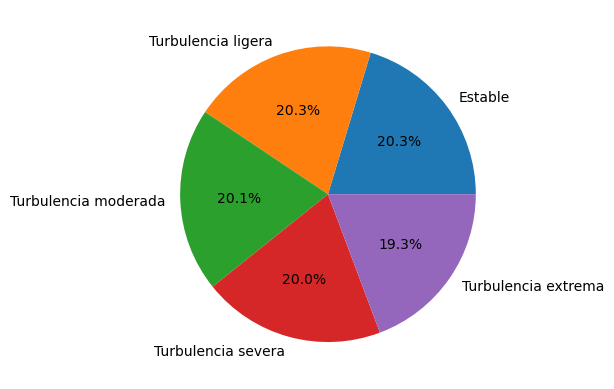

In [4]:
import matplotlib.pyplot as plt

pie_chart = space_X_train["target"].value_counts(normalize=True) * 100

plt.pie(pie_chart,autopct="%1.1f%%", labels = ["Estable","Turbulencia ligera","Turbulencia moderada","Turbulencia severa","Turbulencia extrema"])
plt.show()

El conjunto de datos es equilibrado, todas las categorías contienen aproximadamente un 20% de total por lo cual no es necesario realizar ninguna técnica de undersampling o oversampling. 

Para terminar esta sección realizemos un gráfico con los histogramas de la distribución de las variables de los sensores:

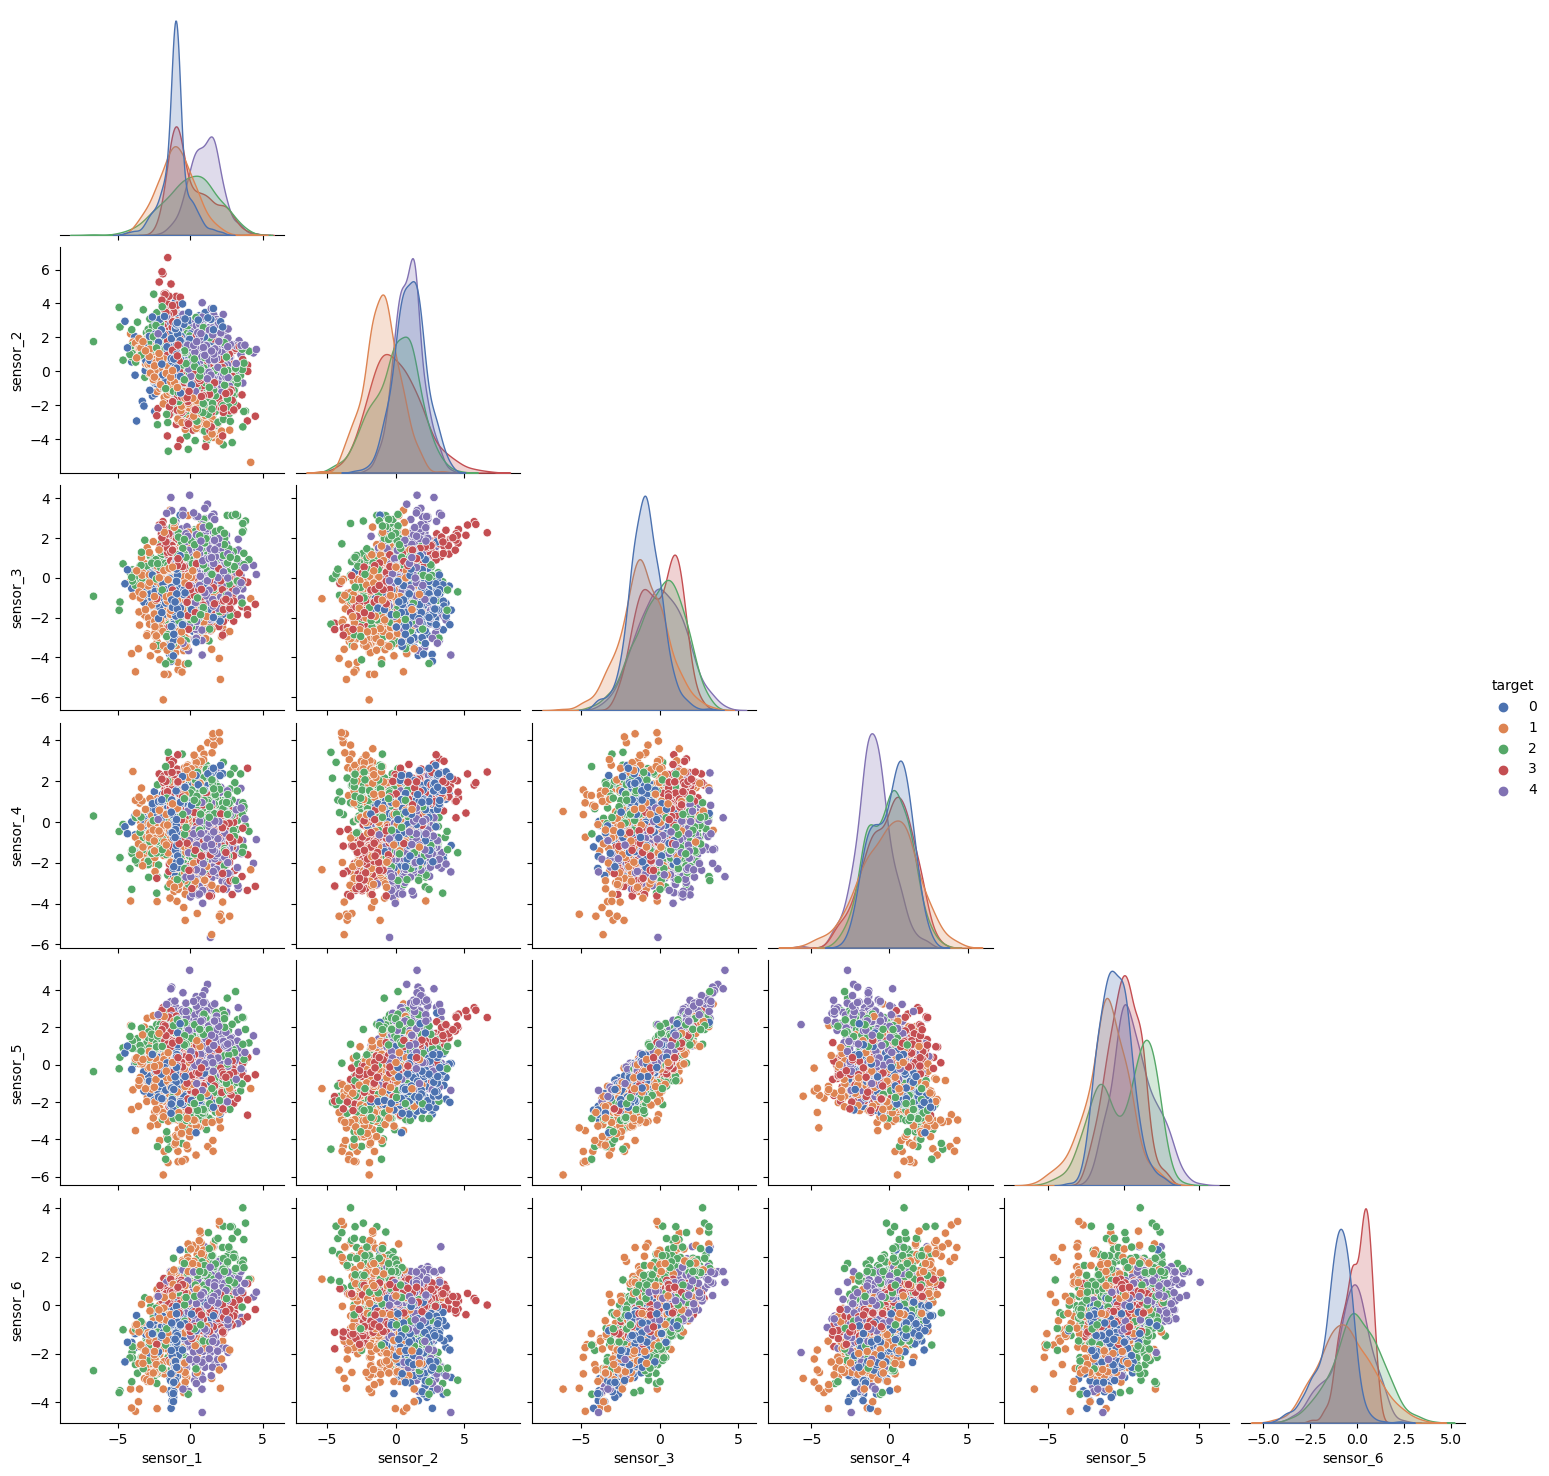

In [5]:
import seaborn as sns

sns.pairplot(space_X_train, hue="target", corner= True ,palette = "deep")
plt.show()

# 2. Entrenamiento y ajuste de los modelos

Vamos a entrenar distintos modelos de predicción con el objetivo de seleccionar el que tenga un mejor rendimiento.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV

Separamos nuestro conjunto de datos en dos dataframes, uno con las variables independientes y otras con el objetivo:

In [3]:
x_train = space_X_train[["sensor_1","sensor_2","sensor_3","sensor_4","sensor_5","sensor_6"]]
y_train = space_X_train[["target"]]

Para entrenar los modelos primero realizaremos un escalamiento con __Robust Scaler__ y luego utlizaremos cada uno de los siguientes clasificación: __K Neighbors Classifier__, __Random Forest Classifier__, __SV Classifier__ y __Gradient Boosting Classifier__.

In [4]:
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

__a) K Neighbors Classifier__ 

Hacemos un pipeline y utilizamos un cross validation score para evaluar el desempeño del modelo con respecto a la métrica f1 macro:

In [5]:
pipe1 = Pipeline([('scaler', RobustScaler()), ('KNC', KNeighborsClassifier())])

score1 = cross_val_score( pipe1, x_train, y_train, cv = 5,scoring = "f1_macro")
score1_mean = score1.mean()
score1_var = np.var(score1)

print("K Neighbors Classifier")
print("Media f1_macro: "+str(score1_mean))
print("Varianza f1_macro: " + str(score1_var))

K Neighbors Classifier
Media f1_macro: 0.7519377388962747
Varianza f1_macro: 0.00012059481868173555


Utilizamos un grid search para afinar los párametros del modelo:

In [6]:
param_grid1 = {
    'KNC__n_neighbors': [3,5,7,9,11,13,15,17,19],
    'KNC__weights': ['uniform','distance'],
    'KNC__metric': ['euclidean','manhattan']
}

search = GridSearchCV(pipe1, param_grid=param_grid1,scoring = "f1_macro",n_jobs=-1)

search.fit(x_train,y_train)
search.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('KNC',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=13,
                                      weights='distance'))])

Evaluamos el desempeño del modelo con los parámetros afinados:

In [7]:
pipe1 = Pipeline(steps=[('scaler', RobustScaler()),
                ('KNC',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=13,
                                      weights='distance'))])

tunscore1= cross_val_score( pipe1, x_train, y_train, cv=5,scoring="f1_macro")

tunscore1_mean = tunscore1.mean()
tunscore1_var = np.var(tunscore1)

print("Tuned K Neighbors Classifier")
print("Media f1_macro: "+str(tunscore1_mean))
print("Varianza f1_macro: " + str(tunscore1_var))

Tuned K Neighbors Classifier
Media f1_macro: 0.7619294883078227
Varianza f1_macro: 6.469244828687852e-05


Realizamos un procedimiento similar con el resto de modelos:

__b) Random Forest Classifier__ 

In [8]:
pipe2 = Pipeline([("scaler", RobustScaler()), ("RFC", RandomForestClassifier(random_state=7))])

score2= cross_val_score( pipe2, x_train, y_train, cv=5,scoring="f1_macro")

score2_mean = score2.mean()
score2_var = np.var(score2)

print("Random Forest Classifier")
print("Media f1_macro: "+str(score2_mean))
print("Varianza f1_macro: " + str(score2_var))

Random Forest Classifier
Media f1_macro: 0.7682874945132088
Varianza f1_macro: 0.00010922253511090809


In [9]:
param_grid2= {
    "RFC__max_depth": [5,10, 15, 20, 25, 30, 35, 40],    
    "RFC__n_estimators": [60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160,170,180,190,200]}

search = GridSearchCV(pipe2, param_grid=param_grid2,scoring = "f1_macro",n_jobs=-1)

search.fit(x_train,y_train)
search.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('RFC',
                 RandomForestClassifier(max_depth=20, n_estimators=160,
                                        random_state=7))])

In [10]:
pipe2 = Pipeline(steps=[ ('scaler', RobustScaler()),
                ('RFC',
                 RandomForestClassifier(max_depth=20, n_estimators=160,
                                        random_state=7))])

tunscore2= cross_val_score( pipe2, x_train, y_train, cv=5,scoring='f1_macro')

tunscore2_mean = tunscore2.mean()
tunscore2_var = np.var(tunscore2)

print("Tuned Random Forest Classifier")
print("Media f1_macro: "+str(tunscore2_mean))
print("Varianza f1_macro: " + str(tunscore2_var))

Tuned Random Forest Classifier
Media f1_macro: 0.7761341382244447
Varianza f1_macro: 8.878839553238514e-05


__c) SV Classifier__ 

In [11]:
pipe3 = Pipeline([('scaler', RobustScaler()), ('SVC', SVC(random_state=7))])

score3= cross_val_score( pipe3, x_train, y_train, cv=5,scoring='f1_macro')

score3_mean = score3.mean()
score3_var = np.var(score3)

print("Support Vector Machine Classifier")
print("Media f1_macro: "+str(score3_mean))
print("Varianza f1_macro: " + str(score3_var))

Support Vector Machine Classifier
Media f1_macro: 0.7501584724036423
Varianza f1_macro: 0.00016258557074223687


In [12]:
param_grid3= {'SVC__C': [0.1,1, 10, 100], 
              'SVC__gamma': ["scale","auto",1,0.1,0.01,0.001],
              'SVC__kernel': ['rbf', 'poly', 'sigmoid']} 
    
search = GridSearchCV(pipe3, param_grid=param_grid3 ,scoring = "f1_macro",n_jobs=-1)

search.fit(x_train,y_train)
search.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('SVC', SVC(C=10, gamma=1, random_state=7))])

In [15]:
pipe3 = Pipeline(steps=[('scaler', RobustScaler()), ('SVC', SVC(C=10, gamma=1, random_state=7))])

tunscore3= cross_val_score( pipe3, x_train, y_train, cv=5,scoring='f1_macro')

tunscore3_mean = tunscore3.mean()
tunscore3_var = np.var(tunscore3)

print("Tuned Support Vector Machine Classifier")
print("Media f1_macro: "+str(tunscore3_mean))
print("Varianza f1_macro: " + str(tunscore3_var))

Tuned Support Vector Machine Classifier
Media f1_macro: 0.7765929765977319
Varianza f1_macro: 0.00020861167293582337


In [16]:
param_grid3= {'SVC__C': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], 
              'SVC__gamma': [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9]} 
    

search = GridSearchCV(pipe3, param_grid=param_grid3 ,scoring = "f1_macro",n_jobs=-1)
search.fit(x_train,y_train)
search.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('SVC', SVC(C=5, gamma=1, random_state=7))])

In [17]:
pipe3 = Pipeline(steps=[('scaler', RobustScaler()), ('SVC', SVC(C=5, gamma=1, random_state=7))])

tunscore3= cross_val_score( pipe3, x_train, y_train, cv=5,scoring='f1_macro')

tunscore3_mean = tunscore3.mean()
tunscore3_var = np.var(tunscore3)

print("Tuned Support Vector Machine Classifier")
print("Media f1_macro: "+str(tunscore3_mean))
print("Varianza f1_macro: " + str(tunscore3_var))

Tuned Support Vector Machine Classifier
Media f1_macro: 0.7822371811734996
Varianza f1_macro: 0.00023504561755287773


__d) Gradient Boosting Classifier__ 

In [18]:
pipe4 = Pipeline([('scaler', RobustScaler()), ('GBC', GradientBoostingClassifier(random_state=7))])

score4= cross_val_score( pipe4, x_train, y_train, cv=5,scoring='f1_macro')

score4_mean = score4.mean()
score4_var = np.var(score4)

print("Gradient Boosting Classifier")
print("Media f1_macro: "+str(score4_mean))
print("Varianza f1_macro: " + str(score4_var))

Gradient Boosting Classifier
Media f1_macro: 0.7421431867455075
Varianza f1_macro: 0.00030021656397859295


In [19]:
param_grid4= {
    'GBC__max_depth': [1,3, 5, 7, 9, 11, 13, 15],    
    'GBC__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,450,500],
    "GBC__learning_rate":[0.01,0.1,1]
}

search = GridSearchCV(pipe4, param_grid=param_grid4 ,scoring = "f1_macro",n_jobs=-1)
search.fit(x_train,y_train)
search.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('GBC',
                 GradientBoostingClassifier(max_depth=7, n_estimators=400,
                                            random_state=7))])

In [20]:
pipe4 = Pipeline(steps=[('scaler', RobustScaler()),
                ('GBC',
                 GradientBoostingClassifier(max_depth=7, n_estimators=400,
                                            random_state=7))])

tunscore4= cross_val_score( pipe4, x_train, y_train, cv=5,scoring='f1_macro')

tunscore4_mean = tunscore4.mean()
tunscore4_var = np.var(tunscore4)

print("Tuned Gradient Boosting Classifier")
print("Media f1_macro: "+str(tunscore4_mean))
print("Varianza f1_macro: " + str(tunscore4_var))

Tuned Gradient Boosting Classifier
Media f1_macro: 0.7620872813807942
Varianza f1_macro: 0.0003284427302479128


In [21]:
param_grid4= {
    'GBC__max_depth': [ 5, 6,7, 8,9],    
    'GBC__n_estimators': [370,380,390,400,410,420,430],
}

search = GridSearchCV(pipe4, param_grid=param_grid4 ,scoring = "f1_macro",n_jobs=-1)
search.fit(x_train,y_train)
search.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('GBC',
                 GradientBoostingClassifier(max_depth=7, n_estimators=420,
                                            random_state=7))])

In [22]:
pipe4 = Pipeline(steps=[('scaler', RobustScaler()),
                ('GBC',
                 GradientBoostingClassifier(max_depth=7, n_estimators=420,
                                            random_state=7))])

tunscore4 = cross_val_score( pipe4, x_train, y_train, cv=5,scoring='f1_macro')

tunscore4_mean = tunscore4.mean()
tunscore4_var = np.var(tunscore4)

print("Tuned Gradient Boosting Classifier")
print("Media f1_macro: "+str(tunscore4_mean))
print("Varianza f1_macro: " + str(tunscore4_var))

Tuned Gradient Boosting Classifier
Media f1_macro: 0.7621538512421762
Varianza f1_macro: 0.00035042294737765124


Presentamos una tabla con un resumen del desempeño de cada uno de los modelos antes y después del ajuste de parámetros:

In [33]:
table_score= pd.DataFrame(data ={"f1_macro mean":[score1_mean,score2_mean,score3_mean,score4_mean], 
                                 "f1_macro var":[score1_var,score2_var,score3_var,score4_var],
                                 "Tuned f1_macro mean":[tunscore1_mean,tunscore2_mean,tunscore3_mean,tunscore4_mean],
                                 "Tuned f1_macro var":[tunscore1_var,tunscore2_var,tunscore3_var,tunscore4_var]                                
                                },index =["RFC","KNC","SVC","GBC"])

table_score

,f1_macro mean,f1_macro var,Tuned f1_macro mean,Tuned f1_macro var
RFC,0.751938,0.000121,0.761929,0.000065
KNC,0.768287,0.000109,0.776134,0.000089
SVC,0.750158,0.000163,0.782237,0.000235
GBC,0.742143,0.000300,0.762154,0.000350


El modelo __SV Classifier__ con parámetros es el que tuvo un mejor desempeño por lo cual lo seleccionemos para realizar las predicciones del test.

# 3. Predicción

Procedemos a realizar la predicción, para eso volvemos a ajustar el modelo __SV Classifier__ con los parámetros que tuvieron un mejor desempeño:

In [5]:
pipe3 = Pipeline(steps=[('scaler', RobustScaler()), ('SVC', SVC(C=5, gamma=1, random_state=7))])

pipe3.fit(x_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('SVC', SVC(C=5, gamma=1, random_state=7))])

Cargamos el test y utilizamos el modelo para realizar la predicción:

In [6]:
x_test = pd.read_csv("space_X_test.csv", index_col = 0)
target_predict = pipe3.predict(x_test)

Convertimos la predicción a un data frame: 

In [7]:
target_predict=pd.DataFrame(target_predict)
target_predict.columns=["target"]
target_predict

,target
0,1
1,3
2,2
3,0
4,3
...,...
895,3
896,4
897,0
898,3


Finalmente convertimos los valores de la predicción a un archivo csv con las características solicitadas:

In [8]:
target_predict.to_csv("space_X_pred.csv", sep='\n', index= False )